<a href="https://colab.research.google.com/github/RafaRuz/Image_classification_no_DL/blob/main/Shazura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/RafaRuz/Image_classification_no_DL

fatal: destination path 'Image_classification_no_DL' already exists and is not an empty directory.


In [2]:
data_dir = 'Image_classification_no_DL/data/'

# Introduction

This notebooks aims to develop an image classifier that allows us to classify images into 4 different classes or categories: Fog, Rain, Sand and Snow.

The source dataset is going to be DAWN (Detection in Adverse Weather Nature), which contains around one thousand images.

In this approach we are not going to use deep learning. The approach will be as follows:
1. **Dataset loading**
2. **EDA (Exploratory Data Analysis)**
  - View some sample images
  - Inspect dimensions, channels and formats
3. **Preprocessing**
  - Encode labels
4. **Feature engineering**
  - **RGB features**: We are going to extract the mean and standard deviation values from the rgb channels. The idea in here is that some weather scenarios may have more presence in different channels, like sand is going to have more red, fog could have more blue, etc.
  -**Grayscale features**: We are going to extract mean, standard deviation, min, max, skewness and kurtosis. Same idea for the first ones. Skewness can help identyfing asymmetry. Kurtosis is related to how condensed the values are around the mean and so it can help identify pictures with low/high contrast.
  -**HSV features**: Mean and standard deviation. Same idea than with RGB, but now we have Hue, Saturation and Value that are related related to brigthness, contrast, etc.
  -**PSD histogram**: Power Spectral Density uses Fourier Transform to transform the image into Frequency Domain. From that, we can get the cummulative amplitude of the signals in a certain frequency. The histogram of these frequencies give us information about which frequencies are more present in the image. Extracting features from the frequency domain is really useful since high frequencies are associated to edges and low frequencies to the "background". So again, it can help identify blurry images in situations like fog.
  -**Texture features (GLCM)**: Gray Level Co-ocurrence Matrix can help us extracting different features like contrast, dissimilarity, homogeneity, ASM, energy and correlation. These features are extracted along different angles and pixel distances and can help identifying textures. The ideal situation is to apply this to patches instead of the whole image after segmenting the image.
  -**Contours**:
  -**Noise features (Laplace filter)**: This filter is a high pass filter and so it's an edge detection filter. If we apply the convolutional filter to the image and the calculate the standard deviation, we can see how edgy the image is.

5. **Dataset processing**: Extract all the features previously described
6. **Classifier training and testing**
7. **Feature selection**
8. **Hyper parameter tuning**

# Packages

In [3]:
# !pip install scikit-image

In [4]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sn
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import numpy as np
from scipy.stats import kurtosis, skew
import math
import matplotlib
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops


# Load dataset

In [5]:
def load_dataset(image_dir):
    '''This function loads in images and their labels and places them in a list
    im_list[0][:] will be the first image-label pair in the list'''
    
    im_list = []
    image_types = ["Fog", "Rain", "Sand", "Snow"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*.jpg")):
            
            # Read in the image
            im = mpimg.imread(file)
            im = np.array(im, dtype=np.uint8)
            
            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type to the image list
                im_list.append((im, im_type))
    
    return np.array(im_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


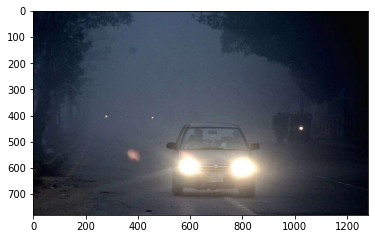

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Change directory to the dataset
# %cd /content/drive/My Drive/Shazura/

# Load the dataset
image_list = load_dataset(data_dir)

# Show sample image
plt.imshow(image_list[0][0]);

In [7]:
# Number of images in each category
unique, counts = np.unique(image_list[:,1], return_counts=True)
label_count = dict(zip(unique, counts))
label_count

{'Fog': 300, 'Rain': 200, 'Sand': 323, 'Snow': 204}

# Preprocessing

In [8]:
# Separate images from labels
le = LabelEncoder()

images = image_list[:,0]
labels_str = image_list[:,1]
labels = le.fit_transform(labels_str)

In [9]:
# Split dataset into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.9, 
                                                    random_state=0, stratify=labels)

In [10]:
# Check the number of samples from each category in the training set
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_label_count = dict(zip(unique_train, counts_train))
train_label_count

{0: 30, 1: 20, 2: 32, 3: 20}

In [11]:
# Crop images
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

for i,img in enumerate(images):
  if np.issubdtype(type(img[0,0]), np.integer):
    if img[0,0] == 0:
      images[i] = crop(img)
  else:
    if img[0,0].sum() == 0:
      images[i] = crop(img)

# Feature engineering

### Average brightness

In [12]:
# # Included in HSV features
# def avg_brightness(img):
#   if len(img.shape) == 3:
#     # Convert image to HSV
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#     # Add up all the pixel values in the V channel
#     sum_brightness = np.sum(hsv[:,:,2])
#     area = img.shape[0]* img.shape[1]

#     # find the avg
#     avg = sum_brightness/area
#   else:
#     avg = cv2.mean(img)[0]
    
#   return avg

### RGB features

In [13]:
def rgb_statistical_features(img):
  if len(img.shape) == 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    
  mean, std = cv2.meanStdDev(img)
  
  return mean.flatten().tolist() +  std.flatten().tolist()

### Grayscale features

In [14]:
def grayscale_statistical_features(img):
  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)

  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  min = img.min()
  max = img.max()
  mean = img.mean()
  std = img.std()
  skewness = skew(img, axis=None)
  kurt = kurtosis(img, axis=None)
    
  return [min, max, mean, std, skewness, kurt]

### HSV features

In [15]:
def hsv_statistical_features(img):
  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
   img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

  if len(img.shape) == 3:
    image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  else:
    image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
  # avg = [cv2.mean(image)[0]]*3
  mean, std = cv2.meanStdDev(image)
    
  # return avg
  return mean.flatten().tolist() +  std.flatten().tolist()

### HSV Saturation histogram

In [16]:
def saturation_histogram_feature(img, nbins=10):
  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
   img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  else:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

  hist = cv2.calcHist([img], [2], None, [nbins], (0,255))

  return hist.flatten().tolist()

### PSD

In [17]:
def PSD_slope_intercept(img):
  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)

  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  ## Fourier Transform along the first axis
  # Round up the size along this axis to an even number
  n = int( math.ceil(img.shape[0] / 2.) * 2 )

  # We use rfft since we are processing real values
  a = np.fft.rfft(img,n, axis=0)

  # Sum power along the second axis
  a = a.real*a.real + a.imag*a.imag
  a = a.sum(axis=1)/a.shape[1]

  # Generate a list of frequencies
  f = np.fft.rfftfreq(n)

  # Graph it
  # plt.figure()
  # plt.plot(f[1:],a[1:], label = 'sum of amplitudes over y vs f_x')

  # Slope and intercept in log-log scale
  X = np.log(f[8:].reshape(len(f[8:]), 1))
  y = np.log(a[8:])
  reg = LinearRegression().fit(X, y)
  slope_first_axis = reg.coef_
  intercept_first_axis = reg.intercept_


  ## Fourier Transform along the second axis
  # Same steps as above
  n = int( math.ceil(img.shape[1] / 2.) * 2 )

  a = np.fft.rfft(img,n,axis=1)

  a = a.real*a.real + a.imag*a.imag
  a = a.sum(axis=0)/a.shape[0]

  f = np.fft.rfftfreq(n)

  # plt.plot(f[8:],a[8:],  label ='sum of amplitudes over x vs f_y')
  # plt.ylabel( 'amplitude' )
  # plt.xlabel( 'frequency' )
  # plt.yscale( 'log' )
  # plt.legend()
  # plt.show()

  # Slope and intercept in log-log scale
  X = np.log(f[8:].reshape(len(f[8:]), 1))
  y = np.log(a[8:])
  reg = LinearRegression().fit(X, y)
  slope_second_axis = reg.coef_
  intercept_second_axis = reg.intercept_

  return [slope_first_axis[0], intercept_first_axis, slope_second_axis[0], intercept_second_axis]

In [18]:
def PSD_histogram(img):
  if len(img.shape) == 3 and img.shape[2] == 4:
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)

  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  ## Fourier Transform along the first axis
  # Round up the size along this axis to an even number
  # n = int( math.ceil(img.shape[0] / 2.) * 2 )
  n = 29 # 15 bins

  # We use rfft since we are processing real values
  a = np.fft.rfft(img,n, axis=0)

  # Sum power along the second axis
  a = a.real*a.real + a.imag*a.imag
  a = a.sum(axis=1)/a.shape[1]

  # Generate a list of frequencies
  f = np.fft.rfftfreq(n)

  # Graph it
  # plt.figure()
  # plt.plot(f[1:],a[1:], label = 'sum of amplitudes over y vs f_x')

  ## Fourier Transform along the second axis
  # Same steps as above
  # n = int( math.ceil(img.shape[1] / 2.) * 2 )
  n = 29 # 15 bins

  a2 = np.fft.rfft(img,n,axis=1)

  a2 = a2.real*a2.real + a2.imag*a2.imag
  a2 = a2.sum(axis=0)/a2.shape[0]

  f = np.fft.rfftfreq(n)

  # plt.plot(f[1:],a2[1:],  label ='sum of amplitudes over x vs f_y')
  # plt.ylabel( 'amplitude' )
  # plt.xlabel( 'frequency' )
  # plt.yscale( 'log' )
  # plt.xscale( 'log' )
  # plt.legend()
  # plt.show()

  # Slope and intercept in log-log scale
  # X = np.log(f[1:].reshape(len(f[1:]), 1))
  # y = np.log(a[1:])
  # reg = LinearRegression().fit(X, y)
  # slope_second_axis = reg.coef_
  # intercept_second_axis = reg.intercept_
  
  # return np.concatenate([a/a.sum(), a2/a2.sum()]).tolist()
  return np.concatenate([a, a2]).tolist()

### Contrast features (GLCM)

In [19]:
def contrast_features(img):
  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)

  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  GLCM = greycomatrix(img, [1, 3, 5], [0, np.pi/4, np.pi/2, 3*np.pi/4])
  contrast = greycoprops(GLCM, 'contrast').flatten()
  dissimilarity = greycoprops(GLCM, 'dissimilarity').flatten()
  homogeneity = greycoprops(GLCM, 'homogeneity').flatten()
  ASM = greycoprops(GLCM, 'ASM').flatten()
  energy = greycoprops(GLCM, 'energy').flatten()
  correlation = greycoprops(GLCM, 'correlation').flatten()

  return np.concatenate([contrast, dissimilarity, homogeneity, ASM, energy, correlation]).tolist()

### Contours

In [20]:
# img = images[0]
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# edges = cv2.Canny(img,100,200)

# contours = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(img, contours[0], -1, (0,255,0), thickness = 2)
# fig, ax = plt.subplots(1, figsize=(12,8))
# plt.imshow(img, 'gray')

### Noise features (Laplace filter)

In [21]:
def laplacian_std(img):
  if len(img.shape) == 3 and img.shape[2] == 4:
   img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
   
  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  return np.sqrt(cv2.Laplacian(img, cv2.CV_64F).var())

### Image segmentation features

In [22]:
# i=1000
# imgray = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
# ret, thresh = cv2.threshold(imgray, 127, 255, 0)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# plt.imshow(cv2.drawContours(images[i], contours, -1, (0,255,0), 3))

## Dataset processing


In [23]:
X_train_features = []

for i, img in enumerate(X_train):
  # print(i)

  # Extract features
  features = []

  # features.append(avg_brightness(img))
  features.extend(grayscale_statistical_features(img))
  features.extend(rgb_statistical_features(img))
  features.extend(hsv_statistical_features(img))
  features.extend(saturation_histogram_feature(img))
  features.extend(PSD_slope_intercept(img))
  features.extend(PSD_histogram(img))
  features.extend(contrast_features(img))
  features.append(laplacian_std(img))

  X_train_features.append(features)

X_train_features = np.asarray(X_train_features)

In [24]:
X_test_features = []

for i, img in enumerate(X_test):
  # Extract features
  features = []

  # features.append(avg_brightness(img))
  features.extend(grayscale_statistical_features(img))
  features.extend(rgb_statistical_features(img))
  features.extend(hsv_statistical_features(img))
  features.extend(saturation_histogram_feature(img))
  features.extend(PSD_slope_intercept(img))
  features.extend(PSD_histogram(img))
  features.extend(contrast_features(img))
  features.append(laplacian_std(img))

  X_test_features.append(features)

X_test_features = np.asarray(X_test_features)

# Training and testing model

Accuracy: 0.667027027027027
ROC AUC score: 0.8558975037221467
              precision    recall  f1-score   support

         Fog       0.64      0.62      0.63       270
        Rain       0.52      0.61      0.56       180
        Sand       0.77      0.74      0.75       291
        Snow       0.72      0.68      0.70       184

    accuracy                           0.67       925
   macro avg       0.66      0.66      0.66       925
weighted avg       0.67      0.67      0.67       925



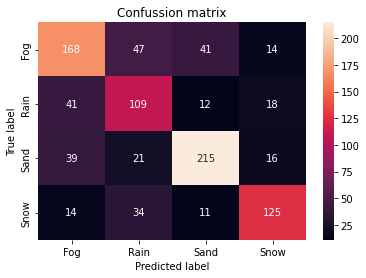

In [25]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# clf = SVC()
# clf = GradientBoostingClassifier()
clf = RandomForestClassifier()
 
clf.fit(X_train_features, y_train)
print(f'Accuracy: {accuracy_score(y_test, clf.predict(X_test_features))}')
print(f'ROC AUC score: {roc_auc_score(y_test, clf.predict_proba(X_test_features), multi_class="ovr")}')
# print(clf.feature_importances_)
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(clf.predict(X_test_features))))

plt.figure()
plt.title('Confussion matrix')
sn.heatmap(confusion_matrix(y_test, clf.predict(X_test_features)), annot=True, fmt='g',
           xticklabels=le.inverse_transform([0,1,2,3]), yticklabels=le.inverse_transform([0,1,2,3]))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Feature selection

In [26]:
# Select the variables that have the most discrimination power

# Model hyperparameter tuning

In [27]:
# Grid search for parameter hypertuning